# Deep Face Detection Model

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect  Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('/kaggle/input/face-data/data/images')
number_images = 30

In [4]:
# cap = cv2.VideoCapture(0)  # Ensure 0 is the correct device index
# if not cap.isOpened():
#     print("Cannot access the camera")
# else:
#     print("Camera accessed successfully")

In [5]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting Image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(1)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

## !Annotate Images with LabelMe

In [6]:
# !labelme

# Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2.3 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files('/kaggle/input/deep-face-detection-data/data/test/images/*.jpg', shuffle=False)

In [10]:
images.as_numpy_iterator().next()

b'/kaggle/input/deep-face-detection-data/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'

In [11]:
def load_image(X):
    byte_img = tf.io.read_file(X)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [14]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View Raw Images With Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

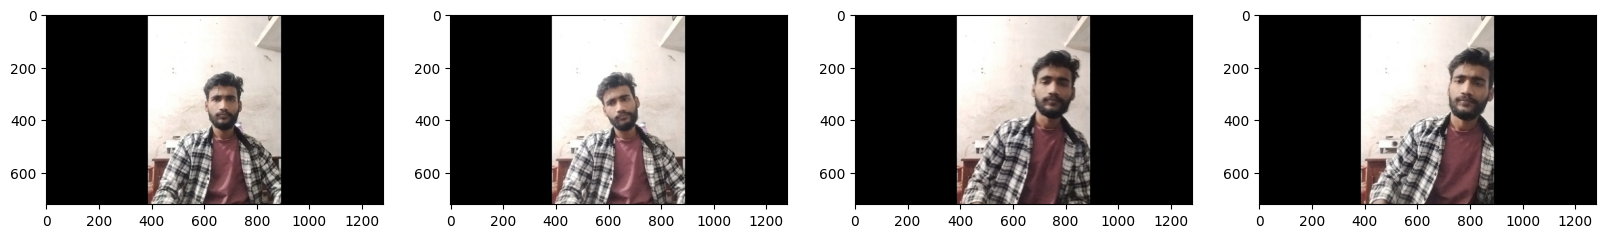

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually Split Data into train test and val

In [18]:
113 * .7 #79 to train

79.1

In [19]:
113 * .15 # 17 and 17 to test and val

16.95

## 3.2 Move the Matching Labels

In [20]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath, new_filepath)

# Albumentations

In [21]:
import albumentations as alb

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [22]:
img = cv2.imread(os.path.join('/kaggle/input/deep-face-detection-data/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'))

In [23]:
img.shape

(720, 1280, 3)

In [24]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1280, height=720),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotaition with OpenCv and JSON

In [25]:
img = cv2.imread(os.path.join('/kaggle/input/deep-face-detection-data/data/train/images/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.jpg'))

In [26]:
with open(os.path.join('/kaggle/input/deep-face-detection-data/data/train/labels/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.json'), 'r') as f:label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[550.9756097560976, 206.3414634146342],
 [749.7560975609756, 446.5853658536586]]

### 4.3 Extract Cordintaes and Rescale to Match image Resolution

In [28]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[550.9756097560976, 206.3414634146342, 749.7560975609756, 446.5853658536586]

In [30]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [31]:
coords

[0.43044969512195125,
 0.2865853658536586,
 0.5857469512195121,
 0.6202574525745258]

### 4.4 Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [33]:
augmented['image'].shape

(720, 1280, 3)

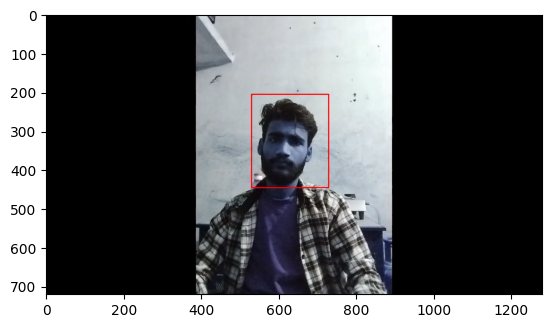

In [34]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1280,720]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)),
              (255, 0, 0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [35]:
# Base paths
base_input_path = '/kaggle/input/deep-face-detection-data/data'
base_output_path = '/kaggle/input/deep-face-detection-data/aug_data'

# Iterate through partitions (train, test, val)
for partition in ['train', 'test', 'val']:
    input_image_path = os.path.join(base_input_path, partition, 'images')
    input_label_path = os.path.join(base_input_path, partition, 'labels')
    output_image_path = os.path.join(base_output_path, partition, 'images')
    output_label_path = os.path.join(base_output_path, partition, 'labels')

    # Create output directories if they do not exist
    os.makedirs(output_image_path, exist_ok=True)
    os.makedirs(output_label_path, exist_ok=True)

    # Process images
    for image in os.listdir(input_image_path):
        img_path = os.path.join(input_image_path, image)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping invalid image: {img_path}")
            continue

        # Default coordinates (for cases where no label exists)
        coords = [0, 0, 0.0001, 0.00001]

        # Get label path
        label_file = f'{os.path.splitext(image)[0]}.json'
        label_path = os.path.join(input_label_path, label_file)

        # Read label data if exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # Extract bounding box coordinates
            coords[0] = label['shapes'][0]['points'][0][0]  # x_min
            coords[1] = label['shapes'][0]['points'][0][1]  # y_min
            coords[2] = label['shapes'][0]['points'][1][0]  # x_max
            coords[3] = label['shapes'][0]['points'][1][1]  # y_max

            # Normalize coordinates (divide by image size)
            coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try:
            # Generate 60 augmentations for each image
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

                # Save augmented image
                output_img_path = os.path.join(output_image_path, f"{os.path.splitext(image)[0]}.{x}.jpg")
                cv2.imwrite(output_img_path, augmented['image'])

                # Create annotation for augmented image
                annotation = {}
                annotation['image'] = f"{os.path.splitext(image)[0]}.{x}.jpg"

                # If bounding boxes exist
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                # Save augmented label
                output_label_file = f"{os.path.splitext(image)[0]}.{x}.json"
                output_label_path = os.path.join(output_label_path, output_label_file)
                with open(output_label_path, 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(f"Error processing {image}: {e}")


OSError: [Errno 30] Read-only file system: '/kaggle/input/deep-face-detection-data/aug_data'